# **DEEP LEARNING**
## LAB 10

In [56]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

In [57]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data directory and transformations
dir = "/kaggle/input/satellite-image-classification/data"
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=dir, transform=transform)

# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print("Training set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))


Training set size: 4504
Validation set size: 563
Test set size: 564


# **Finetune only the last layer and test it**

In [58]:
# Load InceptionNet-V1 (GoogLeNet) using torch.hub.load
inception_v1 = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
inception_v1.to(device)

# Modify last linear layer for fine-tuning
num_ftrs = inception_v1.fc.in_features
inception_v1.fc = nn.Linear(num_ftrs, len(dataset.classes))  # Replace with appropriate number of output classes
inception_v1.fc.to(device)  # Ensure last linear layer is on the same device

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(inception_v1.parameters(), lr=0.001, momentum=0.9)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [59]:
# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    inception_v1.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = inception_v1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    epoch_train_accuracy = correct_train / total_train
    train_accuracies.append(epoch_train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")

    # Validation
    inception_v1.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            val_outputs = inception_v1(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item()

            _, predicted_val = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    epoch_val_accuracy = correct_val / total_val
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")


Epoch 1/10, Train Loss: 0.3987, Train Accuracy: 0.8950
Epoch 1/10, Validation Loss: 0.1281, Validation Accuracy: 0.9716
Epoch 2/10, Train Loss: 0.0551, Train Accuracy: 0.9907
Epoch 2/10, Validation Loss: 0.0128, Validation Accuracy: 1.0000
Epoch 3/10, Train Loss: 0.0341, Train Accuracy: 0.9911
Epoch 3/10, Validation Loss: 0.0308, Validation Accuracy: 0.9929
Epoch 4/10, Train Loss: 0.0218, Train Accuracy: 0.9956
Epoch 4/10, Validation Loss: 0.0093, Validation Accuracy: 0.9982
Epoch 5/10, Train Loss: 0.0192, Train Accuracy: 0.9969
Epoch 5/10, Validation Loss: 0.0030, Validation Accuracy: 1.0000
Epoch 6/10, Train Loss: 0.0178, Train Accuracy: 0.9953
Epoch 6/10, Validation Loss: 0.0040, Validation Accuracy: 0.9982
Epoch 7/10, Train Loss: 0.0143, Train Accuracy: 0.9973
Epoch 7/10, Validation Loss: 0.0020, Validation Accuracy: 1.0000
Epoch 8/10, Train Loss: 0.0119, Train Accuracy: 0.9980
Epoch 8/10, Validation Loss: 0.0026, Validation Accuracy: 1.0000
Epoch 9/10, Train Loss: 0.0127, Train Ac

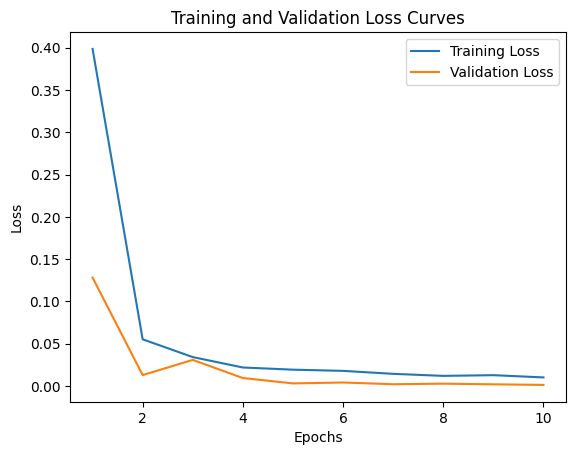

In [60]:
# Plot training and validation loss curves
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()



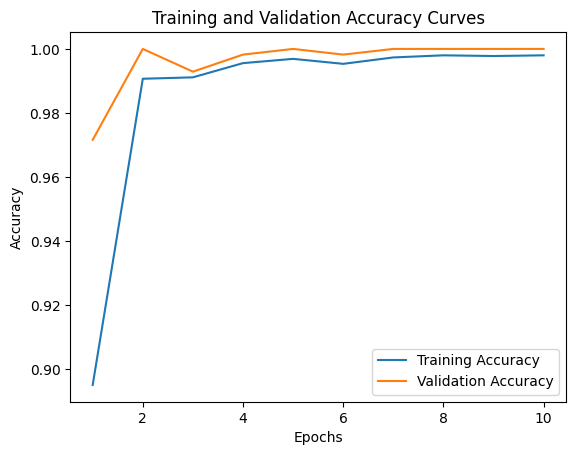

In [61]:
# Plot training and validation accuracy curves
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()


In [62]:
# Test accuracy
inception_v1.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = inception_v1(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = correct_test / total_test
print(f"Test Accuracy after finetuning: {test_accuracy:.4f}")

Test Accuracy after finetuning: 1.0000


In [63]:
# Evaluation on Test Set
inception_v1.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = inception_v1(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate Recall and Accuracy
classification_rep = classification_report(all_labels, all_predictions, target_names=dataset.classes)
accuracy = accuracy_score(all_labels, all_predictions)

print("Classification Report:\n", classification_rep)
print(f"Accuracy: {accuracy:.4f}")


Classification Report:
               precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       143
      desert       1.00      1.00      1.00       125
  green_area       1.00      1.00      1.00       145
       water       1.00      1.00      1.00       151

    accuracy                           1.00       564
   macro avg       1.00      1.00      1.00       564
weighted avg       1.00      1.00      1.00       564

Accuracy: 1.0000


# **Saliency Maps**

In [64]:
# Define paths to images
image_paths = {
    'cloudy': '/kaggle/input/satellite-image-classification/data/cloudy/train_11283.jpg',
    'desert': '/kaggle/input/satellite-image-classification/data/desert/desert(103).jpg',
    'green_area': '/kaggle/input/satellite-image-classification/data/green_area/Forest_1763.jpg',
    'water': '/kaggle/input/satellite-image-classification/data/water/SeaLake_1102.jpg',
}

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


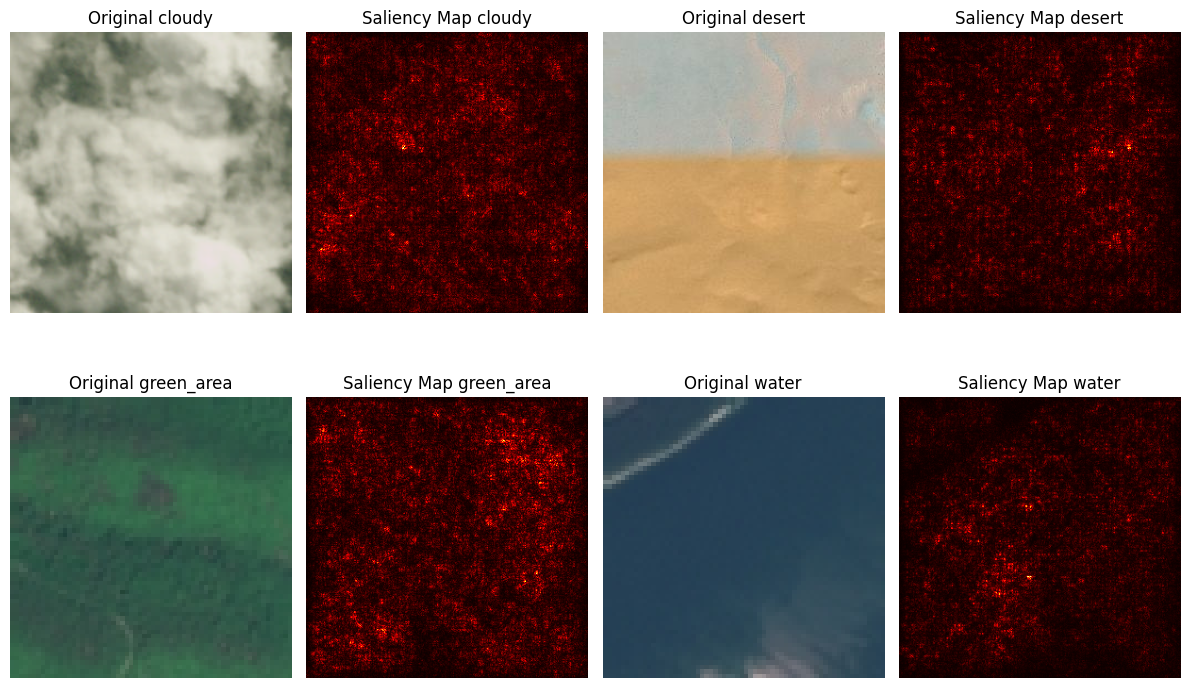

In [65]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load InceptionNet-V1 (GoogLeNet) using torch.hub.load
inception_v1 = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
inception_v1.to(device)

# Define transformations for saliency map generation
saliency_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to a fixed size
    transforms.ToTensor(),
])

# Function to generate saliency map
def generate_saliency_map(image_path, model):
    image = Image.open(image_path)
    image_tensor = saliency_transform(image).unsqueeze(0).to(device)
    image_tensor.requires_grad_()
    
    # Forward pass
    output = model(image_tensor)
    pred_class = output.argmax(dim=1)
    
    # Backward pass to get gradients
    model.zero_grad()
    output[:, pred_class].backward()
    
    # Generate saliency map
    saliency_map = image_tensor.grad.abs().squeeze().cpu().numpy()
    saliency_map = np.amax(saliency_map, axis=0)
    
    return saliency_map

# Plot original images and saliency map images side by side
plt.figure(figsize=(12, 8))
for i, (class_name, image_path) in enumerate(image_paths.items()):
    # Plot original image
    image = Image.open(image_path)
    plt.subplot(2, 4, 2*i+1)
    plt.imshow(image)
    plt.title(f"Original {class_name}")
    plt.axis('off')
    
    # Generate and plot saliency map
    saliency_map = generate_saliency_map(image_path, inception_v1)
    plt.subplot(2, 4, 2*i+2)
    plt.imshow(saliency_map, cmap='hot')
    plt.title(f"Saliency Map {class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# **Re-train the entire network on the new dataset and test it**

In [66]:
# Define data directory and transformations
dir = "/kaggle/input/satellite-image-classification/data"
transform = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=dir, transform=transform)

# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [67]:
# Modify last linear layer for re-training the entire network
num_ftrs = inception_v1.fc.in_features
inception_v1.fc = nn.Linear(num_ftrs, len(dataset.classes))  
inception_v1.fc.to(device)  

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(inception_v1.parameters(), lr=0.001, momentum=0.9)


In [68]:
# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    inception_v1.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = inception_v1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    epoch_train_accuracy = correct_train / total_train
    train_accuracies.append(epoch_train_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")

    # Validation
    inception_v1.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            val_outputs = inception_v1(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item()

            _, predicted_val = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    epoch_val_accuracy = correct_val / total_val
    val_accuracies.append(epoch_val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.4f}")


Epoch 1/10, Train Loss: 0.3709, Train Accuracy: 0.9139
Epoch 1/10, Validation Loss: 0.0375, Validation Accuracy: 0.9964
Epoch 2/10, Train Loss: 0.0579, Train Accuracy: 0.9893
Epoch 2/10, Validation Loss: 0.0185, Validation Accuracy: 1.0000
Epoch 3/10, Train Loss: 0.0342, Train Accuracy: 0.9929
Epoch 3/10, Validation Loss: 0.0556, Validation Accuracy: 0.9858
Epoch 4/10, Train Loss: 0.0308, Train Accuracy: 0.9927
Epoch 4/10, Validation Loss: 0.0171, Validation Accuracy: 0.9982
Epoch 5/10, Train Loss: 0.0202, Train Accuracy: 0.9947
Epoch 5/10, Validation Loss: 0.0046, Validation Accuracy: 1.0000
Epoch 6/10, Train Loss: 0.0246, Train Accuracy: 0.9933
Epoch 6/10, Validation Loss: 0.0054, Validation Accuracy: 1.0000
Epoch 7/10, Train Loss: 0.0102, Train Accuracy: 0.9989
Epoch 7/10, Validation Loss: 0.0026, Validation Accuracy: 1.0000
Epoch 8/10, Train Loss: 0.0178, Train Accuracy: 0.9949
Epoch 8/10, Validation Loss: 0.0020, Validation Accuracy: 1.0000
Epoch 9/10, Train Loss: 0.0110, Train Ac

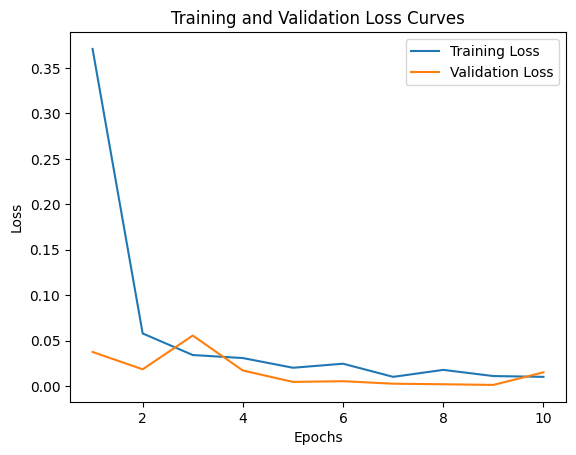

In [69]:
# Plot training and validation loss curves
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

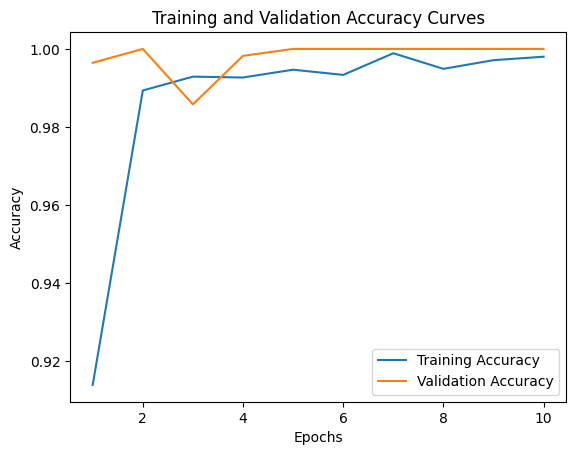

In [70]:
# Plot training and validation accuracy curves
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()


In [71]:
# Test accuracy
inception_v1.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = inception_v1(images)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = correct_test / total_test
print(f"Test Accuracy after re-training the entire network: {test_accuracy:.4f}")

Test Accuracy after re-training the entire network: 0.9965


In [72]:
# Evaluation on Test Set
inception_v1.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = inception_v1(images)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate Recall and Accuracy
classification_rep = classification_report(all_labels, all_predictions, target_names=dataset.classes)
accuracy = accuracy_score(all_labels, all_predictions)

print("Classification Report:\n", classification_rep)
print(f"Accuracy: {accuracy:.4f}")


Classification Report:
               precision    recall  f1-score   support

      cloudy       0.99      1.00      1.00       163
      desert       1.00      1.00      1.00       103
  green_area       1.00      0.99      0.99       143
       water       0.99      1.00      1.00       155

    accuracy                           1.00       564
   macro avg       1.00      1.00      1.00       564
weighted avg       1.00      1.00      1.00       564

Accuracy: 0.9965
